# Tile Coding
## Implementation
Grid tiling is implemented as follows.

In [24]:
%matplotlib inline
import math
# Class Defination of Tile Coding
class TileCoding:
    def __init__(self, tiling_num, tiling_size, tile_length, space_length):
        self.tiling_num = tiling_num
        self.tiling_size = tiling_size
        self.tile_length = tile_length
        self.space_length = space_length
        self.movement = -(tiling_size * tile_length - space_length)/tiling_num
    def gen_code(self, x, y):
        tileIndices = []
        original_x = 0.0
        original_y = 0.0
        for i in range(0, self.tiling_num):
            grid_x = math.floor((x - original_x)/self.tile_length)
            grid_y = math.floor((y - original_y)/self.tile_length)
            tileIndices.append(grid_x * self.tiling_size + grid_y)
            original_x += self.movement
            original_y += self.movement
        return tileIndices
#test TileCoding
#tileCoder = TileCoding(8, 10, 0.6, 5.4)
#print tileCoder.gen_code(0.1, 0.1)
#print tileCoder.gen_code(2.1, 3.1)

# Experiments
## Large Scale CliffWalking
I used a large scale CliffWalking (m and n are greater than 100) to simulate a continue environment and Q-learning as the learning method.

In [57]:
import numpy as np
class CliffWalking:
    def __init__(self, width = 100, height = 100):
        self.width = width
        self.height = height
        self.x = 0
        self.y = 0
    def resetPosition(self):
        self.x = 0
        self.y = 0
    def getReward(self):
        rew = -1
        if self.y == self.height - 1 and self.x == self.width - 1:
            rew = 100
        elif self.y == 0:
            #cliff
            self.resetPosition()
            rew = -100
        else:
            rew = self.x
        return rew
    def move(self, moveType):
        if moveType == 'u':
            if self.y < self.height - 1:
                self.y += 1
        elif moveType == 'd':
            if self.y > 0:
                self.y -= 1
        elif moveType == 'r':
            if self.x < self.width - 1:
                self.x += 1
        elif moveType == 'l':
            if self.x > 0:
                self.x -= 1
        return self.getReward()
    def isEnd(self):
        return (self.x > 0 and self.y == 0) or ((self.y == self.height - 1 and self.x == self.width - 1))
    def getPosition(self):
        return [self.x, self.y]

### Q-learning

In [58]:
actions = ['u', 'd', 'r', 'l']
epsilon = 0.1
#Q Learning
def qLearning_without_tileCoding(cw, width, height, avgR, iterator, max_iter):
    q = np.zeros((width, height, 4))
    G = 0.0
    i = 0
    while not cw.isEnd():
        s0 = cw.getPosition()
        a = q[s0[0], s0[1]].argmax()
        if np.random.random() < epsilon:
            a = np.random.choice(range(4))
        r = cw.move(actions[a])
        G += r
        i += 1
        if i <= max_iter:
            avgR[i] = G / i
        s1 = cw.getPosition()
        q[s0[0], s0[1], a] +=  0.1 * (r + 0.8 * q[s1[0], s1[1]].max() - q[s0[0], s0[1], a])
    iterator.append(i)

### Q-learning with Tile Coding

In [59]:
actions = ['u', 'd', 'r', 'l']
epsilon = 0.1
#Q Learning
def qLearning_with_tileCoding(cw, avgR, iterator, max_iter, tiling_num, tiling_size, tile_length):
    q = {}
    G = 0.0
    i = 0
    tileCoder = TileCoding(tiling_num, tiling_size, tile_length, 100)
    while not cw.isEnd():
        s0 = cw.getPosition()
        tc0 = tileCoder.gen_code(s0[0], s0[1])
        key = ' '.join([str(int(term)) for term in tc0])
        if not key in q:
            q[key] = np.zeros(4)
        a = q[key].argmax()
        if np.random.random() < epsilon:
            a = np.random.choice(range(4))
        r = cw.move(actions[a])
        G += r
        i += 1
        if i <= max_iter:
            avgR[i] = G / i
        s1 = cw.getPosition()
        tc1 = tileCoder.gen_code(s1[0], s1[1])
        key = ' '.join([str(int(term)) for term in tc1])
        if not key in q:
            q[key] = np.zeros(4)
        q[key][a] +=  0.1 * (r + 0.8 * q[key].max() - q[key][a])
    iterator.append(i)

### Comparison
I run 10 times Q-learning with and without tile coding method to compare their performantce.

Average iteration of Q-learning without Tile Coding: 90468.3
Average time of Q-learning without Tile Coding: 0.81798002243
Average iteration of Q-learning with Tile Coding [4, 12]: 9507.48
Average time of Q-learning with Tile Coding [4, 12]: 0.236319956779
Average iteration of Q-learning with Tile Coding [4, 20]: 14232.18
Average time of Q-learning with Tile Coding [4, 20]: 0.35490003109
Average iteration of Q-learning with Tile Coding [8, 12]: 5541.16
Average time of Q-learning with Tile Coding [8, 12]: 0.570880017281


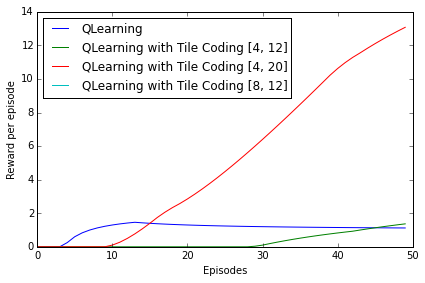

In [66]:
import matplotlib.pyplot as plt
import time
#initialize CliffWalking
cw = CliffWalking()
#without tile coding
time1 = []
ite1 = []
avgR1 = [[0.0]*50] * 50
#num = 4, size = 12 
time2 = []
ite2 = []
avgR2 = [[0.0]*50] * 50
#num = 4, size = 20
time3 = []
ite3 = []
avgR3 = [[0.0]*50] * 50
#num = 8, size = 12
time4 = []
ite4 = []
avgR4 = [[0.0]*50] * 50

for i in range(50):
    cw.resetPosition()
    begin = time.time()
    qLearning_without_tileCoding(cw, 100, 100, avgR1[i], ite1, 49)
    end = time.time()
    time1.append(end - begin)
    cw.resetPosition()
    begin = time.time()
    qLearning_with_tileCoding(cw, avgR2[i], ite2, 49, 4, 12, 12)
    end = time.time()
    time2.append(end - begin)
    cw.resetPosition()
    begin = time.time()
    qLearning_with_tileCoding(cw, avgR3[i], ite3, 49, 4, 20, 6)
    end = time.time()
    cw.resetPosition()
    time3.append(end - begin)
    qLearning_with_tileCoding(cw, avgR4[i], ite4, 49, 8, 12, 12)
    end = time.time()
    time4.append(end - begin)
plt.plot(np.mean(np.asarray(avgR1, dtype=np.float32), axis=0), label = 'QLearning')
print "Average iteration of Q-learning without Tile Coding: " + str(np.mean(ite1))
print "Average time of Q-learning without Tile Coding: " + str(np.mean(time1))
plt.plot(np.mean(np.asarray(avgR2, dtype=np.float32), axis=0), label = 'QLearning with Tile Coding [4, 12]')
print "Average iteration of Q-learning with Tile Coding [4, 12]: " + str(np.mean(ite2))
print "Average time of Q-learning with Tile Coding [4, 12]: " + str(np.mean(time2))
plt.plot(np.mean(np.asarray(avgR3, dtype=np.float32), axis=0), label = 'QLearning with Tile Coding [4, 20]')
print "Average iteration of Q-learning with Tile Coding [4, 20]: " + str(np.mean(ite3))
print "Average time of Q-learning with Tile Coding [4, 20]: " + str(np.mean(time3))
plt.plot(np.mean(np.asarray(avgR4, dtype=np.float32), axis=0), label = 'QLearning with Tile Coding [8, 12]')
print "Average iteration of Q-learning with Tile Coding [8, 12]: " + str(np.mean(ite4))
print "Average time of Q-learning with Tile Coding [8, 12]: " + str(np.mean(time4))
plt.ylabel('Reward per episode')
plt.xlabel('Episodes')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

From the above figure, Q-learning with tile coding needs much fewer steps and time to reach the goal.However, the number and size of tiles have a great influence on the results and need to be carefully selected.

## A Experiment of Parameter Estimation
I also tested and compared their performances on a basic SGD task based on tensorflow to see the effect of tile coding.
### Results of Parameter Estimation

In [ ]:
import tensorflow as tf
import numpy as np

x_data = np.float32(np.random.rand(2, 100))
y_data = np.dot([0.100, 0.200], x_data) + 0.300

#model
b = tf.Variable(tf.zeros([1]))
W = tf.Variable(tf.random_uniform([1, 2], -1.0, 1.0))
y = tf.matmul(W, x_data) + b

loss = tf.reduce_mean(tf.square(y - y_data))
optimizer = tf.train.GradientDescentOptimizer(0.5)
train = optimizer.minimize(loss)

init = tf.initialize_all_variables()

sess = tf.Session()
sess.run(init)

#estimating
for step in xrange(0, 201):
    sess.run(train)
    if step % 20 == 0:
        print step, sess.run(W), sess.run(b), sess.run(loss)

The output of this experiment without tile coding is as follows (this is copied from a machine with GPU),
> 0 [[-0.00485091  0.6484623 ]] [ 0.28584111] 0.0402499

> 20 [[ 0.07618259  0.2899161 ]] [ 0.26610792] 0.000695447

> 40 [[ 0.09791516  0.22105317]] [ 0.29006329] 3.72425e-05

> 60 [[ 0.10039029  0.20508216]] [ 0.29708934] 2.25053e-06


In [ ]:
import tensorflow as tf
import numpy as np

x_data_org = np.float32(np.random.rand(100, 2))
x_data = np.float32(np.zero(100, 8))
tileCoder = TileCoding(8, 20, 0.06, 1)
i = 0
for x in x_data:
    codes = tileCoder.gen_code(x[0], x[1])
    j = 0
    for code in codes:
        x_data[i][j] = code / 400
        j += 1
    i += 1
x_data = x_data.transpose()
y_data = np.dot([0.100, 0.200], x_data_org.transpose()) + 0.300

#model
b = tf.Variable(tf.zeros([1]))
W = tf.Variable(tf.random_uniform([1, 8], -1.0, 1.0))
y = tf.matmul(W, x_data) + b

loss = tf.reduce_mean(tf.square(y - y_data))
optimizer = tf.train.GradientDescentOptimizer(0.5)
train = optimizer.minimize(loss)

init = tf.initialize_all_variables()

sess = tf.Session()
sess.run(init)

#estimating
for step in xrange(0, 201):
    sess.run(train)
    if step % 20 == 0:
        print step, sess.run(W), sess.run(b), sess.run(loss)

The output of this experiment with tile coding is as follows (this is copied from a machine with GPU, the number of tiles is 8 and the size of tiles is 20),
> 0 [[-0.37959146 -0.43442643 -0.84063673 -0.03851473  0.19489717  0.14552462
  -0.43106794  0.06399334]] [ 0.54531169] 0.00582657
  
> 20 [[-0.37959146 -0.43502167 -0.84182721 -0.04030048  0.19251618  0.14254837
  -0.43463942  0.05982658]] [ 0.51584381] 0.00485617
  
> 40 [[-0.37959146 -0.43502167 -0.84182721 -0.04030048  0.19251618  0.14254837
  -0.43463942  0.05982658]] [ 0.51584381] 0.00485617
  
> 60 [[-0.37959146 -0.43502167 -0.84182721 -0.04030048  0.19251618  0.14254837
  -0.43463942  0.05982658]] [ 0.51584381] 0.00485617

When using tile coding, loss (rmse) is bigger than no using it. However as the size of tiles increasing, the model can still be better fitting to the dataset. This is the result when the size of tiles is 100,
> 0 [[ 0.81096244 -0.72231978  0.57849675  0.58854902 -0.49350154 -0.75187999
   0.30046245  0.39356732]] [ 0.45528671] 0.00575172
   
> 20 [[ 0.81096244 -0.72281671  0.57750273  0.58705813 -0.49548948 -0.75436485
   0.29748058  0.39008844]] [ 0.43068367] 0.00507527
   
> 40 [[ 0.81096244 -0.72281671  0.57750273  0.58705813 -0.49548948 -0.75436485
   0.29748058  0.39008844]] [ 0.43068367] 0.00507527
   
> 60 [[ 0.81096244 -0.72281671  0.57750273  0.58705813 -0.49548948 -0.75436485
   0.29748058  0.39008844]] [ 0.43068367] 0.00507527
   